# Mount your google drive and download the dataset

This assignment is based off of this 2D object detection tutorial which uses pytorch to implement the SSD network in order to detect objects in images within the VOC Dataset.
https://github.com/sgrvinod/a-PyTorch-Tutorial-to-Object-Detection

First we mount our google drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Go to the your assignment directory
%cd /content/gdrive/MyDrive/Colab Notebooks/ece495_assignment4
# Where am I?
!ls
## You should have this output:
# /content/gdrive/MyDrive/Colab Notebooks/ece495_assignment4
# ece495_assignment4.ipynb  utils.py  VOC2012  VOC2007
# You might also have the json files if you have already run this
# and also the checkpoint if you have already trained the model

/content/gdrive/MyDrive/Colab Notebooks/ece495_assignment4
checkpoint_ssd300_ResNet.pth.tar	 __pycache__	     utils.py
checkpoint_ssd300_VGG.pth.tar		 TEST_images.json    VOC2007
checkpoint_ssd300_VGG_scheduler.pth.tar  TEST_objects.json   VOC2007_test
ece495_assignment4.ipynb		 TRAIN_images.json
label_map.json				 TRAIN_objects.json


This code only has to be run once. It creates the json files: TRAIN_images.json, TRAIN_objects and label_map.json. These are the image paths, ground truth object information and label to number mapping. This should take 1 hour and 12 minutes.

In [ ]:
from utils import create_data_lists
import time

start = time.time()
create_data_lists(voc07_path='/content/gdrive/MyDrive/Colab Notebooks/ece495_assignment4/VOC2007',
                  voc12_path='/content/gdrive/MyDrive/VOC2012',
                  output_folder='./')
end = time.time()
print("time elapsed:", end - start)

# Create the VOC Dataset loader
Next the Dataset loader for VOC is implemented

In [4]:
import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image
from utils import transform


class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.upper()

        assert self.split in {'TRAIN', 'TEST'}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        with open(os.path.join(data_folder, self.split + '_images.json'), 'r') as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + '_objects.json'), 'r') as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):
        # Read image
        image = Image.open(self.images[i], mode='r')
        image = image.convert('RGB')

        # Read objects in this image (bounding boxes, labels, difficulties)
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects['boxes'])  # (n_objects, 4)
        labels = torch.LongTensor(objects['labels'])  # (n_objects)
        difficulties = torch.ByteTensor(objects['difficulties'])  # (n_objects)

        # Discard difficult objects, if desired
        if not self.keep_difficult:
            boxes = boxes[1 - difficulties]
            labels = labels[1 - difficulties]
            difficulties = difficulties[1 - difficulties]

        # Apply transformations
        image, boxes, labels, difficulties = transform(image, boxes, labels, difficulties, split=self.split)

        return image, boxes, labels, difficulties

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

        This describes how to combine these tensors of different sizes. We use lists.

        Note: this need not be defined in this Class, can be standalone.

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
        difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return images, boxes, labels, difficulties  # tensor (N, 3, 300, 300), 3 lists of N tensors each

# Model Implementation

## Base layers

First we create the base or encoder part of the network.

You must fill in the ResNet code.

In [5]:
from torch import nn
from utils import *
import torch.nn.functional as F
from math import sqrt
from itertools import product as product
import torchvision
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class VGGBase(nn.Module):
    """
    VGG base convolutions to produce lower-level feature maps.
    """

    def __init__(self):
        super(VGGBase, self).__init__()

        # Standard convolutional layers in VGG16
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)  # stride = 1, by default
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)  # ceiling (not floor) here for even dims

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)  # retains size because stride is 1 (and padding)

        # Replacements for FC6 and FC7 in VGG16
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  # atrous convolution

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        # Load pretrained layers
        self.load_pretrained_layers()

    def forward(self, image):
        """
        Forward propagation.

        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv4_3 and conv7
        """
        out = F.relu(self.conv1_1(image))  # (N, 64, 300, 300)
        out = F.relu(self.conv1_2(out))  # (N, 64, 300, 300)
        out = self.pool1(out)  # (N, 64, 150, 150)

        out = F.relu(self.conv2_1(out))  # (N, 128, 150, 150)
        out = F.relu(self.conv2_2(out))  # (N, 128, 150, 150)
        out = self.pool2(out)  # (N, 128, 75, 75)

        out = F.relu(self.conv3_1(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_2(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_3(out))  # (N, 256, 75, 75)
        out = self.pool3(out)  # (N, 256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.conv4_1(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_2(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_3(out))  # (N, 512, 38, 38)
        conv4_3_feats = out  # (N, 512, 38, 38)
        out = self.pool4(out)  # (N, 512, 19, 19)

        out = F.relu(self.conv5_1(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_2(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_3(out))  # (N, 512, 19, 19)
        out = self.pool5(out)  # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))  # (N, 1024, 19, 19)

        conv7_feats = F.relu(self.conv7(out))  # (N, 1024, 19, 19)

        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        """
        As in the paper, we use a VGG-16 pretrained on the ImageNet task as the base network.
        There's one available in PyTorch, see https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.vgg16
        We copy these parameters into our network. It's straightforward for conv1 to conv5.
        However, the original VGG-16 does not contain the conv6 and con7 layers.
        Therefore, we convert fc6 and fc7 into convolutional layers, and subsample by decimation. See 'decimate' in utils.py.
        """
        # Current state of base
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(param_names[:-4]):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_state_dict['classifier.0.weight'].view(4096, 512, 7, 7)  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict['classifier.0.bias']  # (4096)
        state_dict['conv6.weight'] = decimate(conv_fc6_weight, m=[4, None, 3, 3])  # (1024, 512, 3, 3)
        state_dict['conv6.bias'] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_state_dict['classifier.3.weight'].view(4096, 4096, 1, 1)  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict['classifier.3.bias']  # (4096)
        state_dict['conv7.weight'] = decimate(conv_fc7_weight, m=[4, 4, None, None])  # (1024, 1024, 1, 1)
        state_dict['conv7.bias'] = decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

        self.load_state_dict(state_dict)
        print("\nLoaded base model.\n")

class ResNetBase(nn.Module):
    """
    ResNet base convolutions to produce lower-level feature maps.
    """

    def __init__(self):
        super(ResNetBase, self).__init__()

        # TODO: Load pretrained resnet model
        self.resnet = models.resnet34(pretrained=True)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)  # atrous convolution
        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

    def forward(self, image):
        """
        Forward propagation.

        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps
        """
        # # TODO: Add your code
        out = self.resnet.conv1(image)
        out = self.bn1(out)
        out = self.resnet.relu(out)
        out = self.resnet.maxpool(out)

        out = self.resnet.layer1(out)  
        out = self.resnet.layer2(out)  
        concat_copy = out.clone()
        concat_copy_shape = concat_copy.shape

        out = self.resnet.layer3(out)  
        out = self.resnet.layer4(out)
        out = F.interpolate(out, size = (concat_copy_shape[2], concat_copy_shape[3]), mode='bilinear', align_corners=True)

        conv_512_feats = out 
        out = self.pool3(out)

        out = F.relu(self.conv6(out))
        conv_1024_feats = F.relu(self.conv7(out))

        # Lower-level feature maps
        return conv_512_feats, conv_1024_feats

## Auxiliary layers
The base layers created the low level feature maps with 512 and 1024 features.
Now the higher level feature maps are created for 512, 256, 256 and 256 feature maps.

In [6]:
class AuxiliaryConvolutions(nn.Module):
    """
    Additional convolutions to produce higher-level feature maps.
    """

    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()

        # Auxiliary/additional convolutions on top of the VGG base
        self.conv8_1 = nn.Conv2d(1024, 256, kernel_size=1, padding=0)  # stride = 1, by default
        self.conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # dim. reduction because stride > 1

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(128, 256, kernel_size=3, padding=0)  # dim. reduction because padding = 0

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv7_feats):
        """
        Forward propagation.

        :param conv7_feats: lower-level conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :return: higher-level feature maps conv8_2, conv9_2, conv10_2, and conv11_2
        """
        out = F.relu(self.conv8_1(conv7_feats))  # (N, 256, 19, 19)
        out = F.relu(self.conv8_2(out))  # (N, 512, 10, 10)
        conv8_2_feats = out  # (N, 512, 10, 10)

        out = F.relu(self.conv9_1(out))  # (N, 128, 10, 10)
        out = F.relu(self.conv9_2(out))  # (N, 256, 5, 5)
        conv9_2_feats = out  # (N, 256, 5, 5)

        out = F.relu(self.conv10_1(out))  # (N, 128, 5, 5)
        out = F.relu(self.conv10_2(out))  # (N, 256, 3, 3)
        conv10_2_feats = out  # (N, 256, 3, 3)

        out = F.relu(self.conv11_1(out))  # (N, 128, 3, 3)
        conv11_2_feats = F.relu(self.conv11_2(out))  # (N, 256, 1, 1)

        # Higher-level feature maps
        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats

## Prediction layers
At this point we have our 6 feature maps.

The low level feature maps:
(N, 512, 38, 38), (N, 1024, 19, 19)

Also the high level feature maps:
(N, 512, 10, 10), (N, 256, 5, 5), (N, 256, 3, 3), (N, 256, 1, 1)

Each prior box requires a classification output of size number of classes and also the 4 box location values that are regressed. These convolutions are created in the init function.

In the forward pass all the convolutions are performed on their respective input feature maps. After that there is some work done to modify the tensors and then concatonate them in order to have the classification output shaped like (N, 8732, n_classes) and the box output to be (N, 8732, 4). This is a format that will be easier to work with when the network output is passed to the loss function during training or the output is passed through NMS during testing.

In [7]:
class PredictionConvolutions(nn.Module):
    """
    Convolutions to predict class scores and bounding boxes using lower and higher-level feature maps.

    The bounding boxes (locations) are predicted as encoded offsets w.r.t each of the 8732 prior (default) boxes.
    See 'cxcy_to_gcxgcy' in utils.py for the encoding definition.

    The class scores represent the scores of each object class in each of the 8732 bounding boxes located.
    A high score for 'background' = no object.
    """

    def __init__(self, n_classes):
        """
        :param n_classes: number of different types of objects
        """
        super(PredictionConvolutions, self).__init__()

        self.n_classes = n_classes

        # Number of prior-boxes we are considering per position in each feature map
        n_boxes = {'conv4_3': 4,
                   'conv7': 6,
                   'conv8_2': 6,
                   'conv9_2': 6,
                   'conv10_2': 4,
                   'conv11_2': 4}
        # 4 prior-boxes implies we use 4 different aspect ratios, etc.

        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        self.loc_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * 4, kernel_size=3, padding=1)
        self.loc_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * 4, kernel_size=3, padding=1)
        self.loc_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * 4, kernel_size=3, padding=1)

        # Class prediction convolutions (predict classes in localization boxes)
        self.cl_conv4_3 = nn.Conv2d(512, n_boxes['conv4_3'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv7 = nn.Conv2d(1024, n_boxes['conv7'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv8_2 = nn.Conv2d(512, n_boxes['conv8_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv9_2 = nn.Conv2d(256, n_boxes['conv9_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv10_2 = nn.Conv2d(256, n_boxes['conv10_2'] * n_classes, kernel_size=3, padding=1)
        self.cl_conv11_2 = nn.Conv2d(256, n_boxes['conv11_2'] * n_classes, kernel_size=3, padding=1)

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.)

    def forward(self, conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats):
        """
        Forward propagation.

        :param conv4_3_feats: conv4_3 feature map, a tensor of dimensions (N, 512, 38, 38)
        :param conv7_feats: conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :param conv8_2_feats: conv8_2 feature map, a tensor of dimensions (N, 512, 10, 10)
        :param conv9_2_feats: conv9_2 feature map, a tensor of dimensions (N, 256, 5, 5)
        :param conv10_2_feats: conv10_2 feature map, a tensor of dimensions (N, 256, 3, 3)
        :param conv11_2_feats: conv11_2 feature map, a tensor of dimensions (N, 256, 1, 1)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        batch_size = conv4_3_feats.size(0)

        # Predict localization boxes' bounds (as offsets w.r.t prior-boxes)
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  # (N, 16, 38, 38)
        l_conv4_3 = l_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 16), to match prior-box order (after .view())
        # (.contiguous() ensures it is stored in a contiguous chunk of memory, needed for .view() below)
        l_conv4_3 = l_conv4_3.view(batch_size, -1, 4)  # (N, 5776, 4), there are a total 5776 boxes on this feature map

        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 24, 19, 19)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 24)
        l_conv7 = l_conv7.view(batch_size, -1, 4)  # (N, 2166, 4), there are a total 2116 boxes on this feature map

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 24, 10, 10)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 24)
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  # (N, 600, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  # (N, 24, 5, 5)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 24)
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)  # (N, 150, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  # (N, 16, 3, 3)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 16)
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)  # (N, 36, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  # (N, 16, 1, 1)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 16)
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)  # (N, 4, 4)

        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv4_3 = c_conv4_3.permute(0, 2, 3,
                                      1).contiguous()  # (N, 38, 38, 4 * n_classes), to match prior-box order (after .view())
        c_conv4_3 = c_conv4_3.view(batch_size, -1,
                                   self.n_classes)  # (N, 5776, n_classes), there are a total 5776 boxes on this feature map

        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 6 * n_classes, 19, 19)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 6 * n_classes)
        c_conv7 = c_conv7.view(batch_size, -1,
                               self.n_classes)  # (N, 2166, n_classes), there are a total 2116 boxes on this feature map

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 6 * n_classes, 10, 10)
        c_conv8_2 = c_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 6 * n_classes)
        c_conv8_2 = c_conv8_2.view(batch_size, -1, self.n_classes)  # (N, 600, n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  # (N, 6 * n_classes, 5, 5)
        c_conv9_2 = c_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 6 * n_classes)
        c_conv9_2 = c_conv9_2.view(batch_size, -1, self.n_classes)  # (N, 150, n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  # (N, 4 * n_classes, 3, 3)
        c_conv10_2 = c_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 4 * n_classes)
        c_conv10_2 = c_conv10_2.view(batch_size, -1, self.n_classes)  # (N, 36, n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  # (N, 4 * n_classes, 1, 1)
        c_conv11_2 = c_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 4 * n_classes)
        c_conv11_2 = c_conv11_2.view(batch_size, -1, self.n_classes)  # (N, 4, n_classes)

        # A total of 8732 boxes
        # Concatenate in this specific order (i.e. must match the order of the prior-boxes)
        locs = torch.cat([l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1)  # (N, 8732, 4)
        classes_scores = torch.cat([c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2],
                                   dim=1)  # (N, 8732, n_classes)

        return locs, classes_scores

## The SSD300 Model

init - Defines all network layers and created prior boxes

create_prior_boxes - Create 8732 prior boxes across the 6 feature maps

forward - Send the input data through the three network components and then return the predicted locations and classification scores.

detect_objects - After a forward pass the predicted objects can be sent to this function during testing in order to perform NMS for the final output.

### Answer the follwowing questions after reading the NMS code and comparing it to the version in the lecture notes / tutorial.

1. What variables within the batch_size for loop represent "D" and "$\bar{B}$"?

  - We know that in the NMS algorithm (consdier only one obejct in an image) D represents the bounding box that we want (the box with the highest objectiveness, the unsuppressed box), $\bar{B}$ represents all bounding boxes in this image sorted by their objectiveness score(descreasing order).
  - Compare with the relative code, we can find that D is "class_decoded_locs[1 - suppress]"; and $\bar{B}$ is "class_decoded_locs[sort_ind]  or simply "class_decoded_locs"

2. The NMS psuedo code is written with operations such as union and set subtraction. Within the NMS python code how are boxes selected in order to be added to the "D" output

  - Within the NMS python code, using "class_decoded_locs[1 - suppress]" to choose the non-suppress bounding box. (suppress equals to 1 means this box is supporessed, hence [1-supress] means this box is unsuppressed)

In [8]:
class SSD300(nn.Module):
    """
    The SSD300 network - encapsulates the base network, auxiliary, and prediction convolutions.
    """

    def __init__(self, n_classes, base_type):
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        if base_type == 'VGG':
          self.base = VGGBase()
        elif base_type == 'ResNet':
          self.base = ResNetBase()
        else:
          raise NotImplementedError
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)

        # Since lower level features (conv4_3_feats) have considerably larger scales, we take the L2 norm and rescale
        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factors = nn.Parameter(torch.FloatTensor(1, 512, 1, 1))  # there are 512 channels in conv4_3_feats
        nn.init.constant_(self.rescale_factors, 20)

        # Prior boxes
        self.priors_cxcy = self.create_prior_boxes()

    def forward(self, image):
        """
        Forward propagation.

        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        # Run VGG base network convolutions (lower level feature map generators)
        conv4_3_feats, conv7_feats = self.base(image)  # (N, 512, 38, 38), (N, 1024, 19, 19)

        # Rescale conv4_3 after L2 norm
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        conv4_3_feats = conv4_3_feats / norm  # (N, 512, 38, 38)
        conv4_3_feats = conv4_3_feats * self.rescale_factors  # (N, 512, 38, 38)
        # (PyTorch autobroadcasts singleton dimensions during arithmetic)

        # Run auxiliary convolutions (higher level feature map generators)
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = \
            self.aux_convs(conv7_feats)  # (N, 512, 10, 10),  (N, 256, 5, 5), (N, 256, 3, 3), (N, 256, 1, 1)

        # Run prediction convolutions (predict offsets w.r.t prior-boxes and classes in each resulting localization box)
        locs, classes_scores = self.pred_convs(conv4_3_feats, conv7_feats, conv8_2_feats, conv9_2_feats, conv10_2_feats,
                                               conv11_2_feats)  # (N, 8732, 4), (N, 8732, n_classes)

        return locs, classes_scores

    def create_prior_boxes(self):
        """
        Create the 8732 prior (default) boxes for the SSD300, as defined in the paper.

        :return: prior boxes in center-size coordinates, a tensor of dimensions (8732, 4)
        """
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8_2': 10,
                     'conv9_2': 5,
                     'conv10_2': 3,
                     'conv11_2': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8_2': 0.375,
                      'conv9_2': 0.55,
                      'conv10_2': 0.725,
                      'conv11_2': 0.9}

        aspect_ratios = {'conv4_3': [1., 2., 0.5],
                         'conv7': [1., 2., 3., 0.5, .333],
                         'conv8_2': [1., 2., 3., 0.5, .333],
                         'conv9_2': [1., 2., 3., 0.5, .333],
                         'conv10_2': [1., 2., 0.5],
                         'conv11_2': [1., 2., 0.5]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4)

        return prior_boxes

    def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        """
        Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.

        For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.

        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param min_score: minimum threshold for a box to be considered a match for a certain class
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
        :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
        :return: detections (boxes, labels, and scores), lists of length batch_size
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  # (8732, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            # Check for each class
            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

## The MultiBoxLoss

During training the output from the SSD forward pass is then sent to the criterion (set to this function) in order to calculate the loss.

In [9]:
class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.

    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.

        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(device)  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(device)  # (N, 8732)

        # For each image
        for i in range(batch_size):
          # number of objects in this image
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(boxes[i],
                                           self.priors_xy)  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(range(n_objects)).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy)  # (8732, 4)

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(predicted_locs[positive_priors], true_locs[positive_priors])  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(predicted_scores.view(-1, n_classes), true_classes.view(-1))  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = 0.  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        conf_loss_neg, _ = conf_loss_neg.sort(dim=1, descending=True)  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = torch.LongTensor(range(n_priors)).unsqueeze(0).expand_as(conf_loss_neg).to(device)  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (conf_loss_hard_neg.sum() + conf_loss_pos.sum()) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS
        return conf_loss + self.alpha * loc_loss

# Training

With the model implemented it is time to train. Should take 2 hours and 9 minutes for 10 epochs.

In [ ]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
from model import SSD300, MultiBoxLoss
from datasets import PascalVOCDataset
from utils import *
# TODO: Import a learning rate scheduler
from torch.optim.lr_scheduler import StepLR, CosineAnnealingLR, MultiStepLR

# Data parameters
data_folder = './'  # folder with data files
keep_difficult = True  # use objects considered difficult to detect?

# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = len(label_map)  # number of different types of objects
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none
batch_size = 6  # batch size
iterations = 30000 # 120000  # number of iterations to train (DON'T CHANGE)
workers = 4  # number of workers for loading data in the DataLoader
print_freq = 200  # print training status every __ batches
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation

cudnn.benchmark = True

# Overwrite the checkpoint function in utils
def save_checkpoint(epoch, model, optimizer, base_type, scheduler):
    """
    Save model checkpoint.

    :param epoch: epoch number
    :param model: model
    :param optimizer: optimizer
    :param base_type: The base network type
    """
    state = {'epoch': epoch,
             'model': model,
             'optimizer': optimizer,
             'scheduler': scheduler}
    if scheduler == None:
      filename = 'checkpoint_ssd300_' + base_type + '.pth.tar'
    else:
      filename = 'checkpoint_ssd300_' + base_type + '_scheduler.pth.tar'
    torch.save(state, filename)

def train_SSD(base_type, lr_type):
    """
    Training.
    """
    global start_epoch, label_map, epoch, checkpoint, decay_lr_at

    # Custom dataloaders
    train_dataset = PascalVOCDataset(data_folder,
                                     split='train',
                                     keep_difficult=keep_difficult)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               collate_fn=train_dataset.collate_fn, num_workers=workers,
                                               pin_memory=True)  # note that we're passing the collate function here

    if lr_type == 'original_scheduler':
      lr = 1e-3  # learning rate
      decay_lr_at = [20000, 25000] # [80000, 100000]  # decay learning rate after these many iterations
      decay_lr_to = 0.1  # decay learning rate to this fraction of the existing learning rate
    elif lr_type == 'pytorch_scheduler':
      lr = 1e-3 # learning rate
    else:
      raise NotImplementedError

    # Calculate total number of epochs to train and the epochs to decay learning rate at (i.e. convert iterations to epochs)
    # To convert iterations to epochs, divide iterations by the number of iterations per epoch
    # The original paper trains for 120,000 iterations with a batch size of 32, decays after 80,000 and 100,000 iterations
    epochs = iterations // (len(train_dataset) // batch_size)
    print("Number of Epochs to train:", epochs)

    if lr_type == 'original_scheduler':
      decay_lr_at = [it // (len(train_dataset) // batch_size) for it in decay_lr_at]
      print("Epochs to decay learning rate:", decay_lr_at)

    # Initialize model or load checkpoint
    if checkpoint is None:
        start_epoch = 0
        model = SSD300(n_classes=n_classes, base_type=base_type)
        # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
        biases = list()
        not_biases = list()
        for param_name, param in model.named_parameters():
            if param.requires_grad:
                if param_name.endswith('.bias'):
                    biases.append(param)
                else:
                    not_biases.append(param)
        optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
                                    lr=lr, momentum=momentum, weight_decay=weight_decay)
        if lr_type == 'pytorch_scheduler':
          # TODO: Create new scheduler
          scheduler = MultiStepLR(optimizer, milestones=[7, 9], gamma=0.1, last_epoch=-1, verbose=False)
          #scheduler = StepLR(optimizer, step_size=lr, gamma=0.1, last_epoch=-1, verbose=False)
    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint['epoch'] + 1
        print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
        model = checkpoint['model']
        optimizer = checkpoint['optimizer']
        if lr_type == 'pytorch_scheduler':
          # TODO: Load scheduler
          # scheduler = checkpoint['scheduler']
          scheduler = torch.load(scheduler)

    # Move to default device
    model = model.to(device)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

    # Epochs
    for epoch in range(start_epoch, epochs):

        # Decay learning rate at particular epochs
        if lr_type == 'original_scheduler':
          if epoch in decay_lr_at:
              adjust_learning_rate(optimizer, decay_lr_to)

        # One epoch's training
        train(train_loader=train_loader,
              model=model,
              criterion=criterion,
              optimizer=optimizer,
              epoch=epoch)
        
        # TODO: Update the learning rate
        if lr_type == 'pytorch_scheduler':
          scheduler.step()

        # Save checkpoint
        if lr_type == 'original_scheduler':
          save_checkpoint(epoch, model, optimizer, base_type, scheduler=None)
        else:
          # TODO: Call save_checkpoint with your scheduler
          save_checkpoint(epoch, model, optimizer, base_type, scheduler=scheduler)

def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.
    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(images)  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(epoch, i, len(train_loader),
                                                                  batch_time=batch_time,
                                                                  data_time=data_time, loss=losses))
    del predicted_locs, predicted_scores, images, boxes, labels  # free some memory since their histories may be stored


## Training SSD300 with VGG and the original learning rate adjuster

This can be run without making any changes to the code.

In [ ]:
start_time = time.time()
train_SSD(base_type='VGG', lr_type='original_scheduler')
end_time = time.time()
print("time elapsed:", end_time - start_time)

Number of Epochs to train: 10
Epochs to decay learning rate: [7, 9]

Loaded base model.



/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [0][0/2759]	Batch Time 1.774 (1.774)	Data Time 1.404 (1.404)	Loss 23.3955 (23.3955)	
Epoch: [0][200/2759]	Batch Time 0.287 (0.286)	Data Time 0.000 (0.008)	Loss 8.2036 (11.0180)	
Epoch: [0][400/2759]	Batch Time 0.286 (0.280)	Data Time 0.000 (0.004)	Loss 6.7961 (8.8175)	
Epoch: [0][600/2759]	Batch Time 0.261 (0.279)	Data Time 0.000 (0.003)	Loss 5.6785 (7.9680)	
Epoch: [0][800/2759]	Batch Time 0.288 (0.279)	Data Time 0.000 (0.003)	Loss 6.2981 (7.5076)	
Epoch: [0][1000/2759]	Batch Time 0.257 (0.278)	Data Time 0.000 (0.002)	Loss 5.4247 (7.2240)	
Epoch: [0][1200/2759]	Batch Time 0.277 (0.278)	Data Time 0.000 (0.002)	Loss 5.9191 (7.0280)	
Epoch: [0][1400/2759]	Batch Time 0.295 (0.278)	Data Time 0.000 (0.002)	Loss 5.1915 (6.8588)	
Epoch: [0][1600/2759]	Batch Time 0.267 (0.278)	Data Time 0.000 (0.002)	Loss 5.0079 (6.7185)	
Epoch: [0][1800/2759]	Batch Time 0.270 (0.277)	Data Time 0.000 (0.002)	Loss 5.8228 (6.6014)	
Epoch: [0][2000/2759]	Batch Time 0.253 (0.277)	Data Time 0.000 (0.002)	Los

## Training SSD300 with ResNet and the original learning rate adjuster

This should be run after implementing the ResNet Base.

In [ ]:
start_time = time.time()
train_SSD(base_type='ResNet', lr_type='original_scheduler')
end_time = time.time()
print("time elapsed:", end_time - start_time)

Number of Epochs to train: 10
Epochs to decay learning rate: [7, 9]


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [0][0/2759]	Batch Time 105.858 (105.858)	Data Time 104.393 (104.393)	Loss 21.8664 (21.8664)	
Epoch: [0][200/2759]	Batch Time 1.164 (0.967)	Data Time 1.042 (0.829)	Loss 6.6998 (9.1211)	
Epoch: [0][400/2759]	Batch Time 1.107 (0.704)	Data Time 0.984 (0.568)	Loss 6.4495 (7.9832)	
Epoch: [0][600/2759]	Batch Time 0.261 (0.610)	Data Time 0.144 (0.475)	Loss 6.2675 (7.5460)	
Epoch: [0][800/2759]	Batch Time 0.129 (0.562)	Data Time 0.000 (0.428)	Loss 7.2126 (7.3045)	
Epoch: [0][1000/2759]	Batch Time 0.149 (0.539)	Data Time 0.000 (0.404)	Loss 6.8299 (7.1662)	
Epoch: [0][1200/2759]	Batch Time 0.130 (0.521)	Data Time 0.000 (0.387)	Loss 6.7394 (7.0444)	
Epoch: [0][1400/2759]	Batch Time 0.142 (0.508)	Data Time 0.001 (0.374)	Loss 7.0547 (6.9392)	
Epoch: [0][1600/2759]	Batch Time 1.219 (0.500)	Data Time 1.099 (0.367)	Loss 6.8244 (6.8506)	
Epoch: [0][1800/2759]	Batch Time 0.127 (0.494)	Data Time 0.000 (0.361)	Loss 6.0426 (6.7643)	
Epoch: [0][2000/2759]	Batch Time 0.143 (0.488)	Data Time 0.000 (0.3

## Training SSD300 with VGG and using a PyTorch learning rate scheduler

This should be run after modifyng the training loop to use a learning rate scheduler.

In [ ]:
start_time = time.time()
train_SSD(base_type='VGG', lr_type='pytorch_scheduler')
end_time = time.time()
print("time elapsed:", end_time - start_time)

Number of Epochs to train: 10

Loaded base model.



/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch: [0][0/2759]	Batch Time 126.295 (126.295)	Data Time 123.017 (123.017)	Loss 23.3069 (23.3069)	
Epoch: [0][200/2759]	Batch Time 2.784 (1.322)	Data Time 2.473 (1.062)	Loss 6.4519 (10.7817)	
Epoch: [0][400/2759]	Batch Time 2.270 (1.017)	Data Time 1.942 (0.763)	Loss 6.7676 (9.0850)	
Epoch: [0][600/2759]	Batch Time 1.918 (0.915)	Data Time 1.678 (0.661)	Loss 5.9183 (8.2283)	
Epoch: [0][800/2759]	Batch Time 1.003 (0.861)	Data Time 0.758 (0.607)	Loss 6.3973 (7.7605)	
Epoch: [0][1000/2759]	Batch Time 0.247 (0.830)	Data Time 0.000 (0.575)	Loss 6.1305 (7.4524)	
Epoch: [0][1200/2759]	Batch Time 0.994 (0.808)	Data Time 0.746 (0.553)	Loss 5.4685 (7.2168)	
Epoch: [0][1400/2759]	Batch Time 0.252 (0.799)	Data Time 0.000 (0.545)	Loss 6.3343 (7.0401)	
Epoch: [0][1600/2759]	Batch Time 0.249 (0.788)	Data Time 0.000 (0.533)	Loss 4.9598 (6.9061)	
Epoch: [0][1800/2759]	Batch Time 0.252 (0.780)	Data Time 0.000 (0.525)	Loss 5.0622 (6.7854)	
Epoch: [0][2000/2759]	Batch Time 2.098 (0.774)	Data Time 1.841 (0.

# Testing

Now let's run the eval code, it should take about 30 minutes per model.

In [10]:
from utils import *
# from datasets import PascalVOCDataset
from tqdm import tqdm
from pprint import PrettyPrinter

# Good formatting when printing the APs for each class and mAP
pp = PrettyPrinter()

# Parameters
data_folder = './'
keep_difficult = True  # difficult ground truth objects must always be considered in mAP calculation, because these objects DO exist!
batch_size = 64
workers = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint = './checkpoint_ssd300_VGG.pth.tar'

# Load model checkpoint that is to be evaluated
checkpoint = torch.load(checkpoint)
model = checkpoint['model']
model = model.to(device)

# Switch to eval mode
model.eval()

# Load test data
test_dataset = PascalVOCDataset(data_folder,
                                split='test',
                                keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                          collate_fn=test_dataset.collate_fn, num_workers=workers, pin_memory=True)


def evaluate(test_loader, model):
    """
    Evaluate.

    :param test_loader: DataLoader for test data
    :param model: model
    """

    # Make sure it's in eval mode
    model.eval()

    # Lists to store detected and true boxes, labels, scores
    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    true_difficulties = list()  # it is necessary to know which objects are 'difficult', see 'calculate_mAP' in utils.py

    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc='Evaluating')):
            images = images.to(device)  # (N, 3, 300, 300)

            # Forward prop.
            predicted_locs, predicted_scores = model(images)

            # Detect objects in SSD output
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                       min_score=0.01, max_overlap=0.45,
                                                                                       top_k=200)
            # Evaluation MUST be at min_score=0.01, max_overlap=0.45, top_k=200 for fair comparision with the paper's results and other repos

            # Store this batch's results for mAP calculation
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)

        # Calculate mAP
        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

    # Print AP for each class
    pp.pprint(APs)

    print('\nMean Average Precision (mAP): %.3f' % mAP)

## Testing SSD300 with VGG and the original learning rate adjuster

In [ ]:
checkpoint = './checkpoint_ssd300_VGG.pth.tar'

# Load model checkpoint that is to be evaluated
checkpoint = torch.load(checkpoint)
model = checkpoint['model']
model = model.to(device)

# Switch to eval mode
model.eval()

# Load test data
test_dataset = PascalVOCDataset(data_folder,
                                split='test',
                                keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                          collate_fn=test_dataset.collate_fn, num_workers=workers, pin_memory=True)

evaluate(test_loader, model)

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:183: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
Evaluating: 100%|██████████| 78/78 [20:47<00:00, 16.00s/it]


{'aeroplane': 0.7069304585456848,
 'bicycle': 0.7526691555976868,
 'bird': 0.615410327911377,
 'boat': 0.525149941444397,
 'bottle': 0.26577845215797424,
 'bus': 0.768818199634552,
 'car': 0.7888773083686829,
 'cat': 0.833739161491394,
 'chair': 0.38870084285736084,
 'cow': 0.7115549445152283,
 'diningtable': 0.6042712926864624,
 'dog': 0.806510865688324,
 'horse': 0.7746341824531555,
 'motorbike': 0.7582966685295105,
 'person': 0.6959766149520874,
 'pottedplant': 0.2745964825153351,
 'sheep': 0.664925754070282,
 'sofa': 0.6730805039405823,
 'train': 0.7699201703071594,
 'tvmonitor': 0.6671115159988403}

Mean Average Precision (mAP): 0.652


## Testing SSD300 with ResNet and the original learning rate adjuster

In [ ]:
checkpoint = './checkpoint_ssd300_ResNet.pth.tar'

# Load model checkpoint that is to be evaluated
checkpoint = torch.load(checkpoint)
model = checkpoint['model']
model = model.to(device)

# Switch to eval mode
model.eval()

# Load test data
test_dataset = PascalVOCDataset(data_folder,
                                split='test',
                                keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                          collate_fn=test_dataset.collate_fn, num_workers=workers, pin_memory=True)

evaluate(test_loader, model)

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:183: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
Evaluating: 100%|██████████| 78/78 [20:01<00:00, 15.40s/it]


{'aeroplane': 0.667491614818573,
 'bicycle': 0.7133117318153381,
 'bird': 0.6183592081069946,
 'boat': 0.45969194173812866,
 'bottle': 0.20122459530830383,
 'bus': 0.7040727734565735,
 'car': 0.7132814526557922,
 'cat': 0.8372061848640442,
 'chair': 0.3496056795120239,
 'cow': 0.6219093799591064,
 'diningtable': 0.5836526155471802,
 'dog': 0.7992353439331055,
 'horse': 0.7906227111816406,
 'motorbike': 0.7182757258415222,
 'person': 0.6065657734870911,
 'pottedplant': 0.24183790385723114,
 'sheep': 0.5955784320831299,
 'sofa': 0.6600207090377808,
 'train': 0.7756168246269226,
 'tvmonitor': 0.6065837740898132}

Mean Average Precision (mAP): 0.613


## Testing SSD300 with VGG and using a PyTorch learning rate scheduler

In [11]:
checkpoint = './checkpoint_ssd300_VGG_scheduler.pth.tar'

# Load model checkpoint that is to be evaluated
checkpoint = torch.load(checkpoint)
model = checkpoint['model']
model = model.to(device)

# Switch to eval mode
model.eval()

# Load test data
test_dataset = PascalVOCDataset(data_folder,
                                split='test',
                                keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                          collate_fn=test_dataset.collate_fn, num_workers=workers, pin_memory=True)

evaluate(test_loader, model)

Evaluating:   0%|          | 0/78 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:183: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
Evaluating: 100%|██████████| 78/78 [21:47<00:00, 16.76s/it]


{'aeroplane': 0.7154119610786438,
 'bicycle': 0.7397521734237671,
 'bird': 0.6496826410293579,
 'boat': 0.5451831221580505,
 'bottle': 0.2889726161956787,
 'bus': 0.7461641430854797,
 'car': 0.7893444895744324,
 'cat': 0.8354564309120178,
 'chair': 0.3560791015625,
 'cow': 0.7012356519699097,
 'diningtable': 0.5439050793647766,
 'dog': 0.7952905297279358,
 'horse': 0.7889485955238342,
 'motorbike': 0.7635747790336609,
 'person': 0.6894237399101257,
 'pottedplant': 0.303062379360199,
 'sheep': 0.6825856566429138,
 'sofa': 0.6492593288421631,
 'train': 0.7860965132713318,
 'tvmonitor': 0.6727997660636902}

Mean Average Precision (mAP): 0.652


# Viewing results
And lastly let's view some images with our detections!


Loaded checkpoint from epoch 10.



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:183: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:185: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:25.)


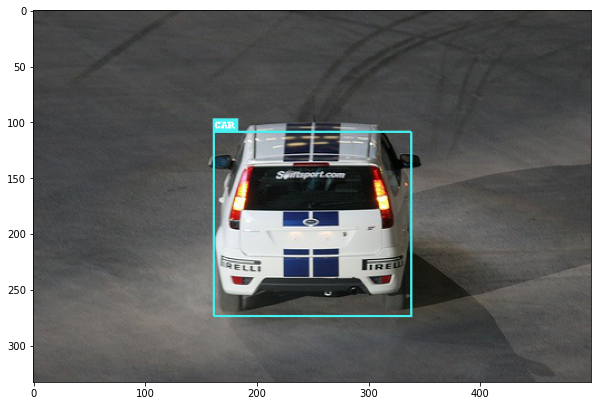

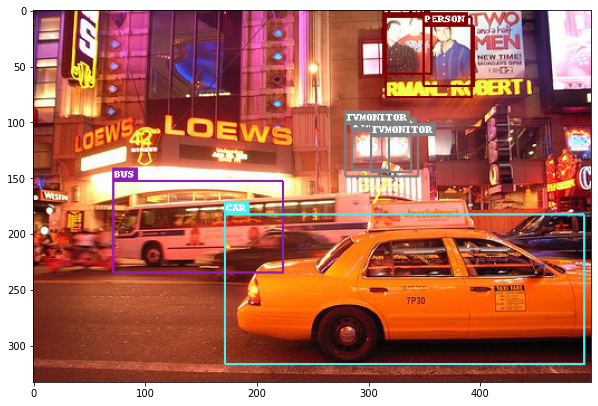

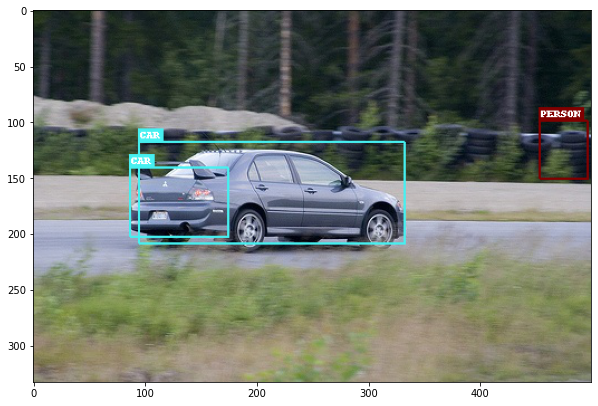

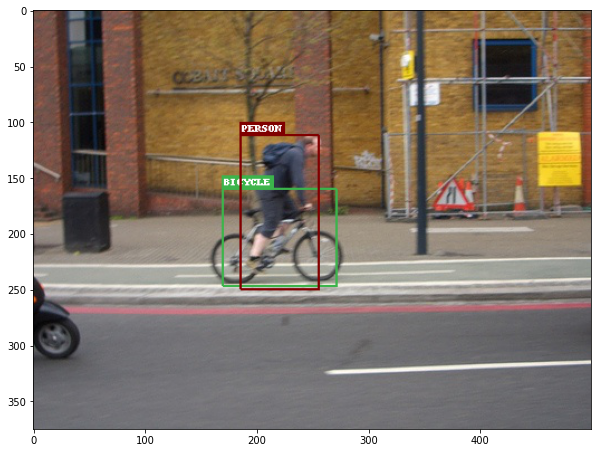

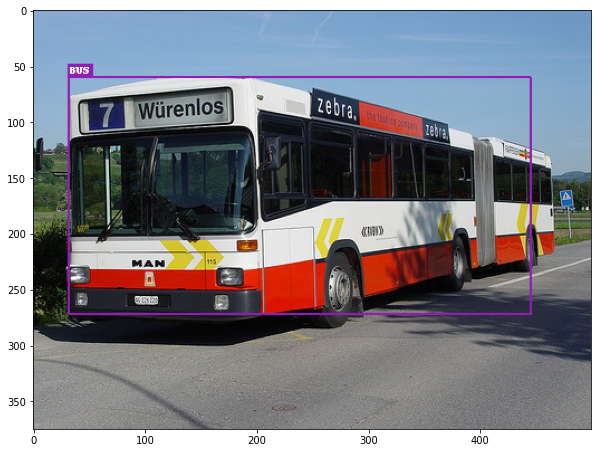

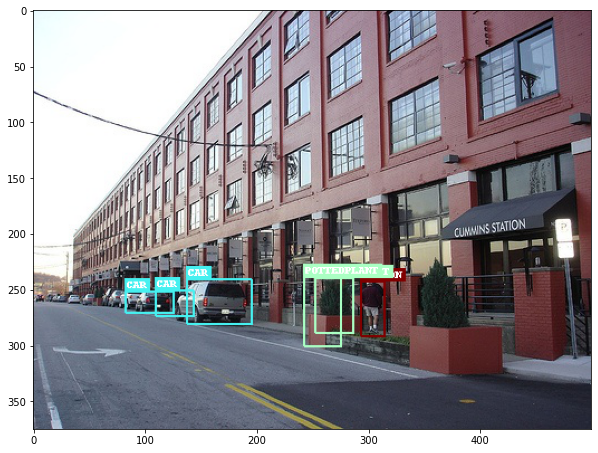

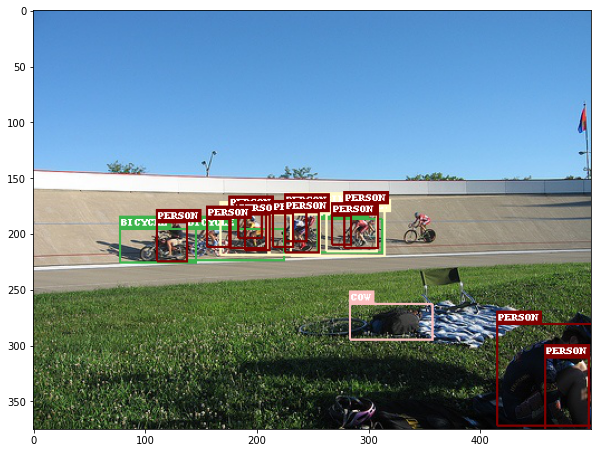

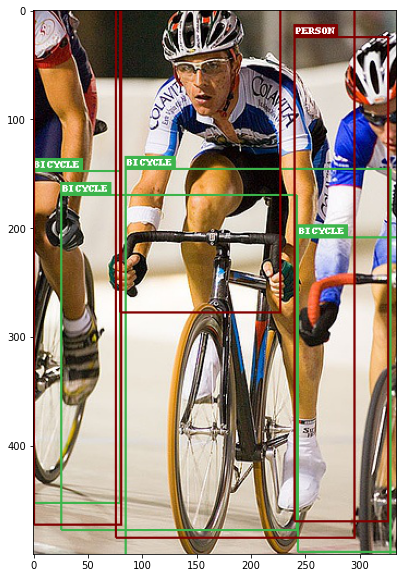

In [13]:
from torchvision import transforms
from utils import *
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model checkpoint
checkpoint = 'checkpoint_ssd300_VGG.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.load_default() # ImageFont.truetype("./calibril.ttf", 15)

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image

relevant_images = [
  '000012.jpg', # Car
  '000014.jpg', # Car, Bus
  '000026.jpg', # Car
  '000038.jpg', # Cyclist
  '000054.jpg', # Bus
  '000091.jpg', # Vehicles parked, far from camera
  '000111.jpg', # Cyclists in race, far from camera
  '000129.jpg' # Cyclists in race, close to camera
]

for rel_img_file_name in relevant_images:
    img_path = '/content/gdrive/MyDrive/Colab Notebooks/ece495_assignment4/VOC2007/JPEGImages/' + rel_img_file_name
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    img = detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200)

    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(1,1,1)
    ax1.imshow(img)